In [1]:
import os
import numpy as np
import theano
import theano.tensor as T
import pandas as pd
import matplotlib.pyplot as plt
from layers import LSTMLayer, InputLayer, FullyConnectedLayer
from lib import get_params, make_caches, SGD, momentum, create_optimization_updates
from basic_lstm import basicLSTM
%matplotlib inline

In [2]:
def _load_data(data, n_prev=3):  
    """
    data should be pd.DataFrame()
    """
    docX, docY = [], []
    for i in range(len(data)-n_prev):
        docX.append(data.data.iloc[i:i+n_prev])
        docY.append(data.response.iloc[i+n_prev]) 

    alsX = np.array(docX)
    alsY = np.array(docY)
    return np.matrix(alsX), np.matrix(alsY).T

def data_generation_noise(stopTime, numPoints, n_prev, noiseSD):
    """
    Inputs:
    stopTime - stop time for the sine series
    numPoints - Resolution
    n_prev - previous points to include for prediction
    """
    noise = np.random.normal(loc=0, scale=noiseSD ,size=numPoints)
    if n_prev > 1:
        startTime = 0
        time_vec = np.linspace(startTime, stopTime, num=numPoints)
        x = np.sin(time_vec) + noise
        data = pd.DataFrame({"data":x, "response":x})
        data.response = data.response.shift(-1)
        #Not selecting the last point since the response is a Nan
        data = data.iloc[:-1]
        data_mat, resp_mat = _load_data(data, n_prev=n_prev)
    else:
        time_vec = np.linspace(0, 20, numPoints)
        data = np.sin(time_vec) + noise
        data_rolled = np.roll(data, -1)[:-1]
        data_mat = np.matrix(data[:-1]).T
        resp_mat = np.matrix(data_rolled).T
    return data_mat, resp_mat, time_vec[n_prev:]


def mv_data_generation_noise(numPoints, L, n_prev, noiseSD):
    mean = np.zeros(numPoints)
    vec = np.array([[j for j in range(0,numPoints)] for k in range(0,numPoints)])
    covMat = np.exp(-(vec - vec.T)**2/float(L**2))
    noise = np.random.normal(loc=0, scale=noiseSD ,size=numPoints)
    x = np.random.multivariate_normal(mean, covMat, size=(1,))[0] + noise
    time_vec = range(numPoints)
    if n_prev > 1:
        data = pd.DataFrame({"data":x, "response":x})
        data.response = data.response.shift(-1)
        #Not selecting the last point since the response is a Nan
        data = data.iloc[:-1]
        data_mat, resp_mat = _load_data(data, n_prev=n_prev)
    else:
        data = x
        data_rolled = np.roll(data, -1)[:-1]
        data_mat = np.matrix(data[:-1]).T
        resp_mat = np.matrix(data_rolled).T
    return data_mat, resp_mat, time_vec[n_prev:]

In [4]:
stopTime = 20
numPoints = 200
n_prev = 1
noise = 0.2
n_iterations = 1000
data_mat, resp_mat, time_vec = data_generation_noise(stopTime, numPoints, n_prev, noise)

In [8]:
data_mat_tr = data_mat[:numPoints/2,:]
resp_mat_tr = resp_mat[:numPoints/2,:] 
#Creating the LSTM model
lstm_model = basicLSTM(n_prev)
#eta - learning rate
eta = 0.5
#alpha - momentum hyperparameter
alpha = 1.0

In [17]:
for i in range(n_iterations):
    r_cost = lstm_model.train(data_mat_tr, resp_mat_tr, alpha)

In [13]:
import seaborn as sns

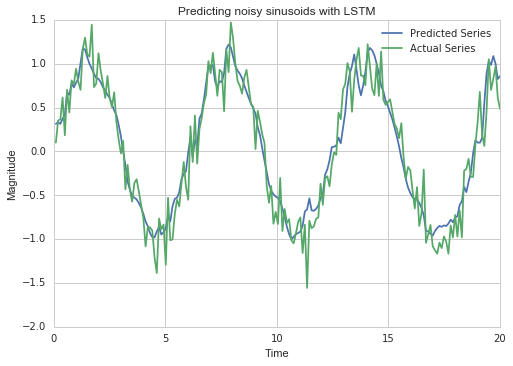

In [19]:
sns.set_style("whitegrid")
plt.plot(time_vec, lstm_model.predict(data_mat)[0], label='Predicted Series')
plt.plot(time_vec, resp_mat, label='Actual Series')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.legend()
plt.title('Predicting noisy sinusoids with LSTM')
plt.savefig('../irr_sin.png')

#### Irregular series

In [54]:
def acc_vel_irregular(stopTime, numPoints, numSelPoints, noise):
    time = np.linspace(0, stopTime, numPoints)
    data = np.sin(time) + np.random.normal(loc=0, scale=noise, size=numPoints)
    index = np.sort(np.random.choice(range(numPoints), size=numSelPoints, replace=False))
    time_irr = time[index]
    data_irr = data[index]
    delta_t = [0] + list(np.array(time_irr[1:]) - np.array(time_irr[:-1]))
    derivative = np.divide(np.diff(data_irr), np.diff(time_irr))
    magDerivative = np.lib.pad(derivative, (1,0), 'constant', constant_values=(0,0))
    dDerivative = np.lib.pad(np.diff(magDerivative), (1,0), 'constant', constant_values=(0,0))
    data_mat = np.matrix([list(data_irr), delta_t, list(magDerivative), list(dDerivative)]).T
    data_mat = data_mat[:-1,:]
    resp_mat = np.matrix(np.roll(data_irr, -1)[:-1]).T
    time_vec = time_irr[1:]
    return data_mat, resp_mat, time_vec

In [70]:
stopTime = 20
numPoints = 400
numSelPoints = 60
noise=0.1
data_mat, resp_mat, time_vec = acc_vel_irregular(stopTime, numPoints, numSelPoints, noise)
data_mat_tr = data_mat[:numSelPoints/2,:]
resp_mat_tr = resp_mat[:numSelPoints/2,:]
#eta - learning rate
eta = 0.5
#alpha - momentum hyperparameter
alpha = 1.0
n_iterations = 1000
n_prev = 1

In [76]:
lstm_model = basicLSTM(4, 20)

In [77]:
for i in range(n_iterations):
    """
    data_mat_n, resp_mat_n, _ = acc_vel_irregular(stopTime, numPoints, numSelPoints, noise)
    data_mat_tr = data_mat_n[:numSelPoints/2,:]
    resp_mat_tr = resp_mat_n[:numSelPoints/2,:]
    """
    r_cost = lstm_model.train(data_mat_tr, resp_mat_tr, alpha)

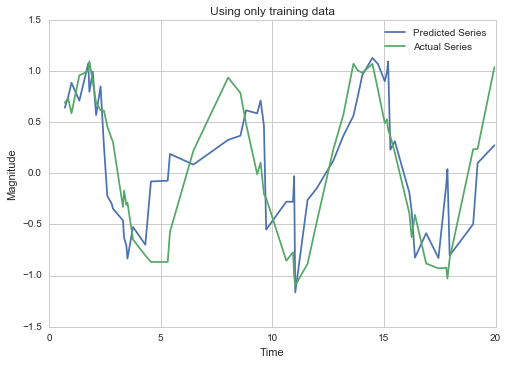

In [78]:
sns.set_style("whitegrid")
plt.plot(time_vec, lstm_model.predict(data_mat)[0], label='Predicted Series')
plt.plot(time_vec, resp_mat, label='Actual Series')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.legend()
plt.title('Using only training data')
plt.savefig('../irr_sin_noise_tr.png')

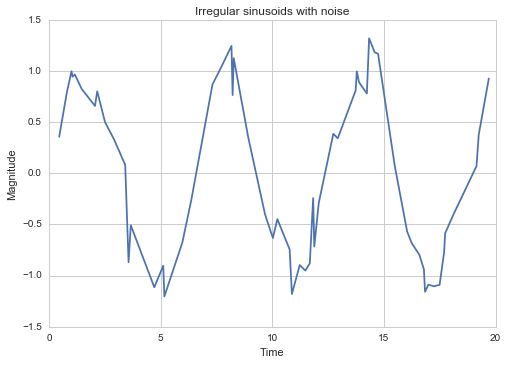

In [59]:
plt.plot(time_vec, resp_mat)
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.legend()
plt.title('Irregular sinusoids with noise')
plt.savefig('../irr_sin_slide2.png')

### LPV

In [79]:
#only visible files
def listdir_nohidden(path):
    list_files = []
    for f in os.listdir(path):
        if not f.startswith('.'):
            list_files.append(f)
    return list_files

In [80]:
#Getting the list of files
datapath = os.path.join(os.getcwd(), 'data/LPV/')
list_files = listdir_nohidden(datapath)
#suffix = [files.split('.')[3] for files in list_files]
#Starter code when we want to use different bands for analysis
file_sel = list_files[0]
print "Processing LPV file :",file_sel

Processing LPV file : lc_1.3319.10.B.mjd


In [81]:
def acc_vel_irregular_dataset(data):
    np.random.seed()
    data_arr = np.array(data)
    err = np.array(data['Err\n'])
    err_list = []
    for er in err:
        err_list.append(np.random.normal(0,er))
    err_arr = np.array(err_list)
    time_irr = data_arr[:,0] - data_arr[0,0]
    data_mean = np.mean(data_arr[:,1])
    data_irr = data_arr[:,1] + err_arr - data_mean
    delta_t = [0] + list(np.array(time_irr[1:]) - np.array(time_irr[:-1]))
    derivative = np.divide(np.diff(data_irr), np.diff(time_irr))
    magDerivative = np.lib.pad(derivative, (1,0), 'constant', constant_values=(0,0))
    dDerivative = np.lib.pad(np.diff(magDerivative), (1,0), 'constant', constant_values=(0,0))
    data_mat = np.matrix([list(data_irr), delta_t, list(magDerivative), list(dDerivative)]).T
    data_mat = data_mat[:-1,:]
    resp_mat = np.matrix(np.roll(data_irr, -1)[:-1]).T
    time_vec = time_irr[1:]
    return data_mat, resp_mat, time_vec, data_mean

In [82]:
filepath = os.path.join(datapath, file_sel)
data = []
with open(filepath) as f:
    lines = f.readlines()
    header = [str(val) for val in lines[2].split(' ')]
    for line in lines[3:]:
        data.append([float(val) for val in line.split(' ')])
data_df = pd.DataFrame(data)
data_df.columns = header

In [83]:
lstm_model = basicLSTM(4, num_cells=50)
numIterations = 1000

In [84]:
for i in range(numIterations):
    data_mat, resp_mat, time_vec, data_mean = acc_vel_irregular_dataset(data_df)
    numSelPoints = len(data_df)
    data_mat_tr = data_mat[:numSelPoints/2,:]
    resp_mat_tr = resp_mat[:numSelPoints/2,:]
    r_cost = lstm_model.train(data_mat_tr, resp_mat_tr, 1.0)

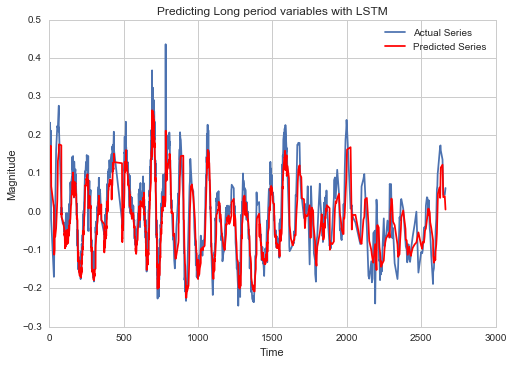

In [87]:
sns.set_style("whitegrid")
plt.plot(time_vec, resp_mat, label='Actual Series')
plt.plot(time_vec, lstm_model.predict(data_mat)[0], label='Predicted Series', color='r')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.legend()
plt.title('Predicting Long period variables with LSTM')
plt.savefig('../lpv.png')

In [86]:
data_mat, resp_mat, time_vec, data_mean = acc_vel_irregular_dataset(data_df)

In [9]:
data_mat[2]

matrix([[ 0.22183691,  0.967407  ,  0.00466725,  0.00950832]])

In [23]:
def gen_impluse(stopTime, numPoints, alpha, sigma_error, p_bernoulli, irregular=False, selPoints=50):
    time = np.linspace(0, stopTime, numPoints)
    noise = np.random.normal(loc=0, scale=sigma_error, size=numPoints)
    cauchy = np.random.standard_cauchy(numPoints)
    bernoulli = np.random.binomial(1, p_bernoulli, size=numPoints)
    data = np.zeros(numPoints)
    data[0] = noise[0] + bernoulli[0]*cauchy[0]
    for i in range(1,numPoints):
        data[i] = alpha*data[i-1] + noise[i] + bernoulli[i]*cauchy[i]
    if irregular == False:
        resp_mat = np.matrix(data[1:]).T
        time_vec = time[1:]
        data_mat = np.matrix(data[:-1]).T
        return data_mat, resp_mat, time_vec
    else:
        index = np.sort(np.random.choice(range(numPoints), size=selPoints, replace=False))
        time_irr = time[index]
        data_irr = data[index]
        delta_t = [0] + list(np.array(time_irr[1:]) - np.array(time_irr[:-1]))
        derivative = np.divide(np.diff(data_irr), np.diff(time_irr))
        magDerivative = np.lib.pad(derivative, (1,0), 'constant', constant_values=(0,0))
        dDerivative = np.lib.pad(np.diff(magDerivative), (1,0), 'constant', constant_values=(0,0))
        data_mat = np.matrix([list(data_irr), delta_t, list(magDerivative), list(dDerivative)]).T
        data_mat = data_mat[:-1,:]
        resp_mat = np.matrix(np.roll(data_irr, -1)[:-1]).T
        time_vec = time_irr[1:]
        return data_mat, resp_mat, time_vec

In [30]:
stopTime = 20
numPoints = 200
sigma_error = 0.2
alpha = 1.0
p_bernoulli = 0.05
data_mat, resp_mat, time_vec = gen_impluse(stopTime, numPoints, alpha, sigma_error, p_bernoulli)

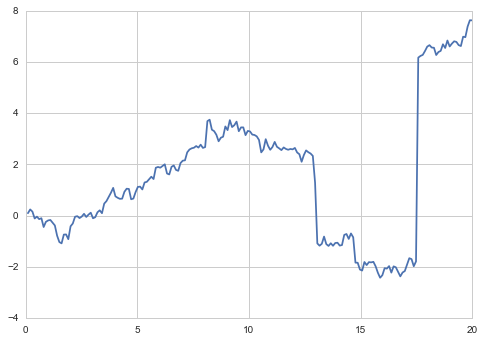

In [31]:
plt.plot(time_vec, resp_mat)
plt.legend()
plt.savefig('../impulse.png')

In [32]:
import pandas as pd

In [48]:
err = pd.read_csv('graphs/mv-regular-time-with-noise-test/error-graphs/error_trajectory_noise_0.5.csv')

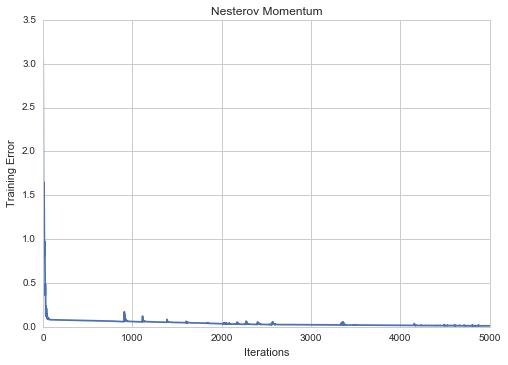

In [49]:
plt.plot(err['Error'])
plt.xlabel('Iterations')
plt.ylabel('Training Error')
plt.title('Nesterov Momentum')
plt.savefig('../nm.png')

In [50]:
err = pd.read_csv('graphs/mv-regular-time-with-noise-test-ad/error-graphs/error_trajectory_noise_0.4.csv')

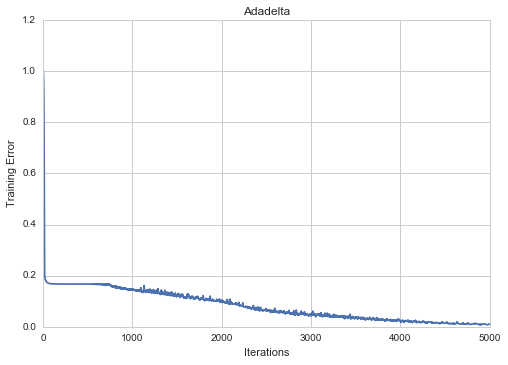

In [52]:
plt.plot(err['Error'])
plt.xlabel('Iterations')
plt.ylabel('Training Error')
plt.title('Adadelta')
plt.savefig('../adadelta.png')